In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [4]:
dataset=torchvision.datasets.MNIST(root='./kaggle/working', train=True, transform=transform, download=True)
dataloader=DataLoader(dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]


Extracting ./kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to ./kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]


Extracting ./kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to ./kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.40MB/s]


Extracting ./kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to ./kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]

Extracting ./kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./kaggle/working/MNIST/raw



In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(noise_dim, 256*7*7),
            nn.ReLU(True),
            nn.Unflatten(1,(256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), #14*14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,1,kernel_size=4, stride=2, padding=1), #28*28
            nn.Tanh()
        )

    def forward(self,x):
        return self.net(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 100
G = Generator(noise_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
lr = 0.0002
G_opt = optim.Adam(G.parameters(), lr=lr)
D_opt = optim.Adam(D.parameters(), lr=lr)


In [8]:
epochs = 50
G_losses = []
D_losses = []

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # REAL and FAKE labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -------------------
        # Train Discriminator
        # -------------------
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        D_loss = real_loss + fake_loss

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # ----------------
        # Train Generator
        # ----------------
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(z)
        G_loss = criterion(D(fake_imgs), real_labels)  # Generator wants to trick D

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {D_loss:.4f}  G_loss: {G_loss:.4f}")


Epoch [1/50]  D_loss: 0.0031  G_loss: 6.5693
Epoch [2/50]  D_loss: 0.0005  G_loss: 7.9830
Epoch [3/50]  D_loss: 0.0002  G_loss: 9.2034
Epoch [4/50]  D_loss: 0.0083  G_loss: 6.7923
Epoch [5/50]  D_loss: 0.0002  G_loss: 9.3228
Epoch [6/50]  D_loss: 0.0009  G_loss: 9.6361
Epoch [7/50]  D_loss: 0.0002  G_loss: 9.7685
Epoch [8/50]  D_loss: 0.0001  G_loss: 10.7373
Epoch [9/50]  D_loss: 0.0000  G_loss: 11.2848
Epoch [10/50]  D_loss: 0.0003  G_loss: 8.7764
Epoch [11/50]  D_loss: 0.0136  G_loss: 6.3263
Epoch [12/50]  D_loss: 0.0119  G_loss: 6.8343
Epoch [13/50]  D_loss: 0.1200  G_loss: 4.2781
Epoch [14/50]  D_loss: 0.1876  G_loss: 3.4022
Epoch [15/50]  D_loss: 0.1971  G_loss: 3.2875
Epoch [16/50]  D_loss: 0.3657  G_loss: 3.7948
Epoch [17/50]  D_loss: 0.2369  G_loss: 2.6551
Epoch [18/50]  D_loss: 0.1504  G_loss: 2.6818
Epoch [19/50]  D_loss: 0.4205  G_loss: 2.5045
Epoch [20/50]  D_loss: 0.3011  G_loss: 2.9902
Epoch [21/50]  D_loss: 0.2357  G_loss: 3.7871
Epoch [22/50]  D_loss: 0.3256  G_loss: 2.

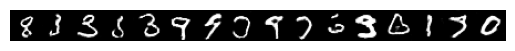

In [9]:
z = torch.randn(16, noise_dim).to(device)
samples = G(z).cpu().detach()

grid = torch.cat([samples[i] for i in range(16)], dim=2).squeeze()
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()


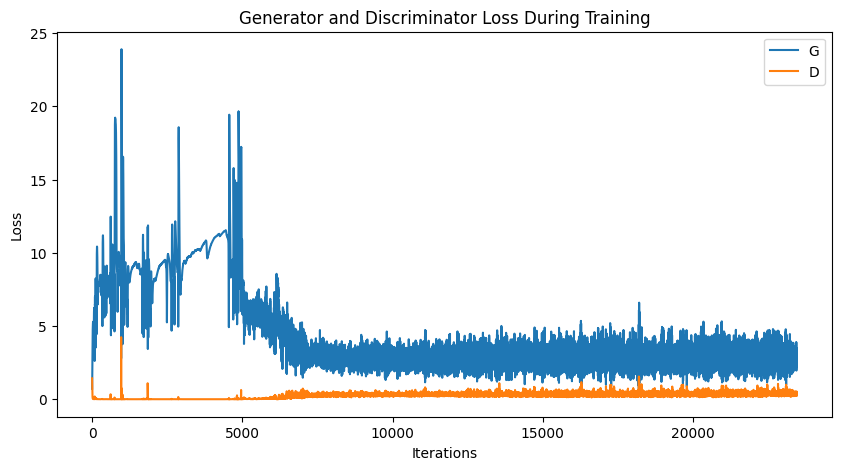

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss During Training')
plt.show()


In [11]:
epochs = 100
G_losses = []
D_losses = []

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # REAL and FAKE labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -------------------
        # Train Discriminator
        # -------------------
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        D_loss = real_loss + fake_loss

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # ----------------
        # Train Generator
        # ----------------
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(z)
        G_loss = criterion(D(fake_imgs), real_labels)  # Generator wants to trick D

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {D_loss:.4f}  G_loss: {G_loss:.4f}")


Epoch [1/100]  D_loss: 0.3184  G_loss: 2.6896
Epoch [2/100]  D_loss: 0.4388  G_loss: 2.5188
Epoch [3/100]  D_loss: 0.3177  G_loss: 1.6226
Epoch [4/100]  D_loss: 0.3892  G_loss: 4.4089
Epoch [5/100]  D_loss: 0.2926  G_loss: 1.6215
Epoch [6/100]  D_loss: 0.2464  G_loss: 3.6743
Epoch [7/100]  D_loss: 0.4720  G_loss: 2.5454
Epoch [8/100]  D_loss: 0.2569  G_loss: 2.9661
Epoch [9/100]  D_loss: 0.2815  G_loss: 4.9469
Epoch [10/100]  D_loss: 0.3360  G_loss: 2.5427
Epoch [11/100]  D_loss: 0.4680  G_loss: 2.0969
Epoch [12/100]  D_loss: 0.2515  G_loss: 2.5442
Epoch [13/100]  D_loss: 0.2153  G_loss: 2.9354
Epoch [14/100]  D_loss: 0.4797  G_loss: 2.8774
Epoch [15/100]  D_loss: 0.2201  G_loss: 1.9905
Epoch [16/100]  D_loss: 0.4546  G_loss: 2.9444
Epoch [17/100]  D_loss: 0.3064  G_loss: 2.1949
Epoch [18/100]  D_loss: 0.3413  G_loss: 2.6916
Epoch [19/100]  D_loss: 0.3952  G_loss: 2.5776
Epoch [20/100]  D_loss: 0.5780  G_loss: 3.9407
Epoch [21/100]  D_loss: 0.3937  G_loss: 3.2474
Epoch [22/100]  D_loss

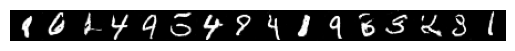

In [12]:
z = torch.randn(16, noise_dim).to(device)
samples = G(z).cpu().detach()

grid = torch.cat([samples[i] for i in range(16)], dim=2).squeeze()
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()


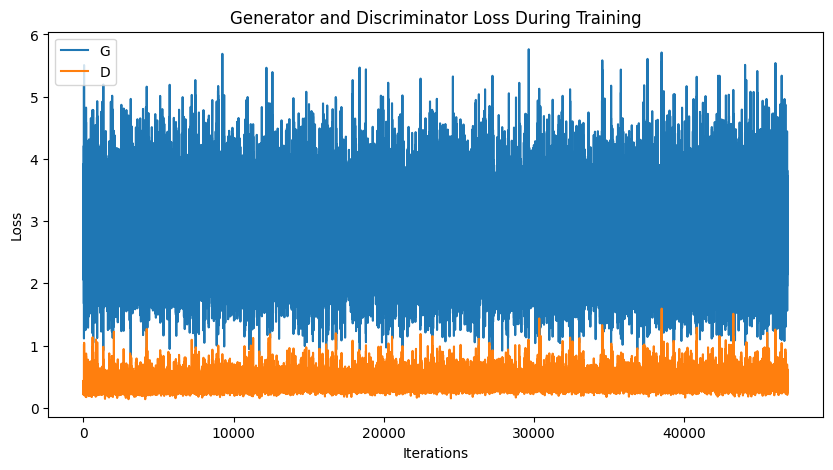

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss During Training')
plt.show()


In [14]:
epochs = 150
G_losses = []
D_losses = []

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # REAL and FAKE labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -------------------
        # Train Discriminator
        # -------------------
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        D_loss = real_loss + fake_loss

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # ----------------
        # Train Generator
        # ----------------
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(z)
        G_loss = criterion(D(fake_imgs), real_labels)  # Generator wants to trick D

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {D_loss:.4f}  G_loss: {G_loss:.4f}")


Epoch [1/150]  D_loss: 0.2782  G_loss: 2.5841
Epoch [2/150]  D_loss: 0.4093  G_loss: 3.4123
Epoch [3/150]  D_loss: 0.4853  G_loss: 2.7589
Epoch [4/150]  D_loss: 0.6208  G_loss: 1.9039
Epoch [5/150]  D_loss: 0.3759  G_loss: 2.2838
Epoch [6/150]  D_loss: 0.3970  G_loss: 2.5965
Epoch [7/150]  D_loss: 0.4639  G_loss: 1.0805
Epoch [8/150]  D_loss: 0.4420  G_loss: 3.1129
Epoch [9/150]  D_loss: 0.2779  G_loss: 3.0533
Epoch [10/150]  D_loss: 0.6622  G_loss: 4.2662
Epoch [11/150]  D_loss: 0.5091  G_loss: 1.4905
Epoch [12/150]  D_loss: 0.4409  G_loss: 3.7293
Epoch [13/150]  D_loss: 0.2708  G_loss: 3.4676
Epoch [14/150]  D_loss: 0.4027  G_loss: 2.5449
Epoch [15/150]  D_loss: 0.3229  G_loss: 4.2293
Epoch [16/150]  D_loss: 0.3655  G_loss: 3.5749
Epoch [17/150]  D_loss: 0.3046  G_loss: 4.1921
Epoch [18/150]  D_loss: 0.5773  G_loss: 3.3264
Epoch [19/150]  D_loss: 0.4209  G_loss: 3.8686
Epoch [20/150]  D_loss: 0.5432  G_loss: 2.7586
Epoch [21/150]  D_loss: 0.6564  G_loss: 2.3083
Epoch [22/150]  D_loss

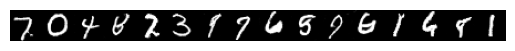

In [15]:
z = torch.randn(16, noise_dim).to(device)
samples = G(z).cpu().detach()

grid = torch.cat([samples[i] for i in range(16)], dim=2).squeeze()
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()


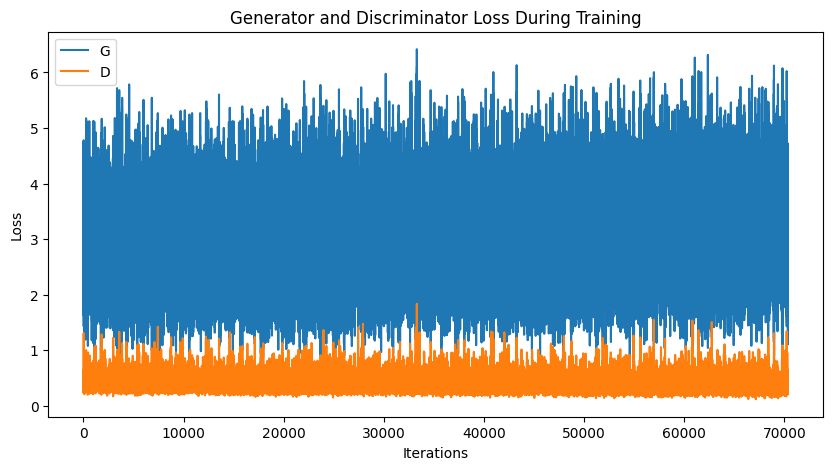

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss During Training')
plt.show()
